<a href="https://colab.research.google.com/github/lekhana2211/Machine-Learning-Projects/blob/main/%F0%9F%98%B9Sarcasm_Detection%7C_NLP_and_TF_%7C_For_Beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'news-headlines-dataset-for-sarcasm-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F30764%2F533474%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T212949Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b6f868c0d82f201299a33be5a90bae1e05d75beebc7df42a3e28040722054f277c64575e0e2c3598361cbd63bc0d53e955451f904b154ce4deb27913e264a7b3b6bf0c54d11a5de1ae070d025fd9578fbe7df9f2af6ff551f10a8c9ec85cc8f60d278917a6716aff24233a3475114d8ae3d637cf3fa9433b03a6cc71f265efb493573bb800fcbbf25a1962f5bd4d7c6209296c6fb6ba4ed6861e7e274395b7289465fd1c03366d10c0cf5c8954363d9240b8766fd50cd6ccca126ad53ace0a255468bb97b7ced2fc0f645913a6bfda1c4b604c4fec0fa03171c95b2e1c52f63b8cf937b57678b74cfed3f3ec216d42947a621974e6e99f37ec6690a75894c4e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3460534 bytes downloaded
Downloaded and uncompressed: news-headlines-dataset-for-sarcasm-detection
Data source import complete.


<a id="1"></a>
# Information about the dataset:
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

![image.png](attachment:382bef47-0e96-4a94-a592-92c9d8620f84.png)

> **Table of Contents:**
> * [Information about the dataset](#1)
> * [Importing Libraries](#2)
> * [Loading Data](#3)
> * [EDA - Exploratory Data Analysis](#4)
> * [PreProcessing](#5)
> * [Tokenization and Padding](#6)
> * [Data Modeling](#7)
> ---

<a id="2"></a>
# 1. Importing Libraries 📚

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import nltk
import re
import re,string,unicodedata
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")


<a id="3"></a>
# 2. Loading the Data 📅

In [3]:
import pandas as pd
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


<a id="4"></a>
# 3. Let's Explore 👓 - Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
df.shape

(28619, 3)

In [7]:
#checking for null values in train data
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [8]:
df.describe(include='object')

,headline,article_link
count,28619,28619
unique,28503,28617
top,"'no way to prevent this,' says only nation whe...",https://politics.theonion.com/nation-not-sure-...
freq,12,2


In [9]:
#checking for duplicate values
df['headline'].duplicated().sum()

116

**Dropping Duplicates**

In [10]:
df=df.drop(df[df['headline'].duplicated()].index,axis=0)

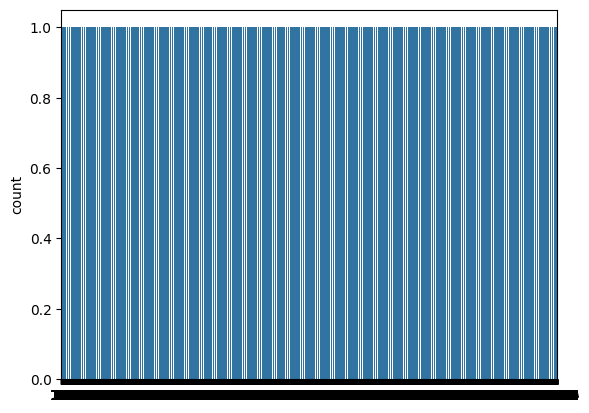

In [11]:
sns.countplot(df['is_sarcastic']);

<a id="5"></a>
# 4. Preprocessing  🤠

# 4.A.Stopwords removal

In [12]:
# this function is copied from another kernel. Don't know who is the original author of it.
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [13]:
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

NameError: name 'denoise_text' is not defined

In [14]:
labels = (df['is_sarcastic'])
data = (df['headline'])

# 4.B. Splitting the Data ✂

In [15]:
train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

train_data = data[:train_size]
train_labels= labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]


<a id="6"></a>
# 4.C. Tokenizaton and Padding 🗿

In [16]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)



27684


In [17]:
maxlen=max([len(i) for i in train_sequences])

In [18]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen,  padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen,  padding='post')

## Differnce between normal sentence, tokenized sequence and padded sequence?

In [19]:
# Print a sample headline
index = 10
print(f'sample headline: {train_sequences[index]}')
print(f'padded sequence: {train_padded[index]} \n')

print(f'Original Sentence:  \n {tokenizer.sequences_to_texts(train_sequences[index:index+1])} \n')

# Print dimensions of padded sequences
print(f'shape of padded sequences: {train_padded.shape}')

sample headline: [23, 2166, 11, 3013, 7, 411, 5, 3230, 9, 72, 1130, 43, 15, 26]
padded sequence: [  23 2166   11 3013    7  411    5 3230    9   72 1130   43   15   26
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0] 

Original Sentence:  
 ['this lesbian is considered a father in indiana and an amazing one at that'] 

shape of padded sequences: 

<a id="7"></a>
# 5. Data Modeling - LSTMMMMMMMMM!!! 🤖

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,100,input_length=maxlen),
    tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 152, 100)          2768500   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [21]:
history=model.fit(train_padded, np.array(train_labels),validation_data = (test_padded,np.array(test_labels)) , epochs = 5 , verbose=2)

Epoch 1/5
713/713 - 387s - loss: 0.3800 - accuracy: 0.8201 - val_loss: 0.3054 - val_accuracy: 0.8670 - 387s/epoch - 543ms/step
Epoch 2/5
713/713 - 397s - loss: 0.1483 - accuracy: 0.9454 - val_loss: 0.3602 - val_accuracy: 0.8574 - 397s/epoch - 557ms/step
Epoch 3/5
713/713 - 394s - loss: 0.0574 - accuracy: 0.9804 - val_loss: 0.4960 - val_accuracy: 0.8481 - 394s/epoch - 553ms/step
Epoch 4/5
713/713 - 397s - loss: 0.0276 - accuracy: 0.9907 - val_loss: 0.6050 - val_accuracy: 0.8462 - 397s/epoch - 557ms/step
Epoch 5/5
713/713 - 397s - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.7664 - val_accuracy: 0.8402 - 397s/epoch - 557ms/step


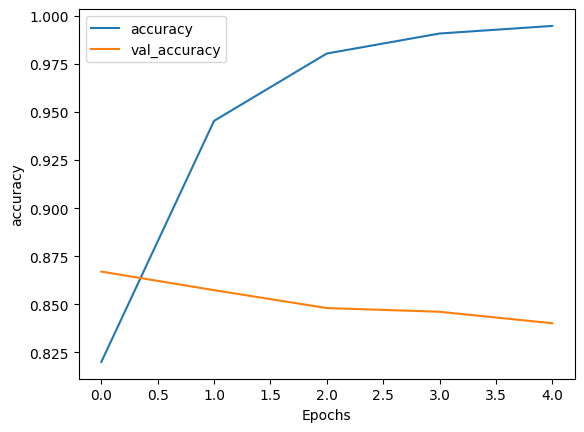

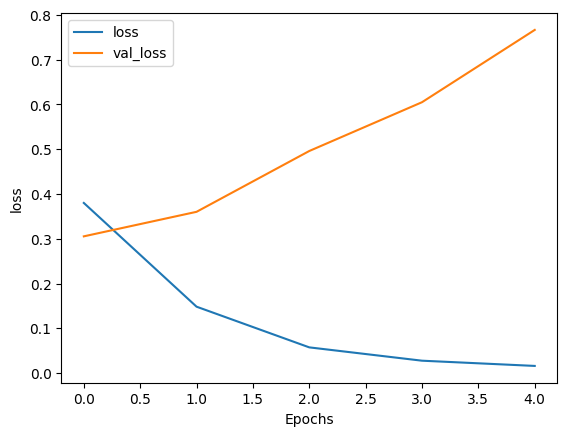

In [22]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### <center>Thanks for reading:)</center>
### <center>Upvote! and Leave some suggestions</center>